In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:45285 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [3]:
temp_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/monthly_TNn_all_members_1x1.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110})
temp_data = temp_ds.TMP2m
temp_data
# Detrend temp data
temp_data_dt = temp_data.groupby('time.month').map(func.detrend_by_month_ufunc).chunk(chunks={'member':1, 'time':-1, 'lat':110, 'lon':110})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [4]:
temp_data_dt

,Array,Chunk
Bytes,76.94 GiB,183.89 MiB
Shape,"(80, 1992, 180, 360)","(1, 1992, 110, 110)"
Count,1329921 Tasks,640 Chunks
Type,float64,numpy.ndarray


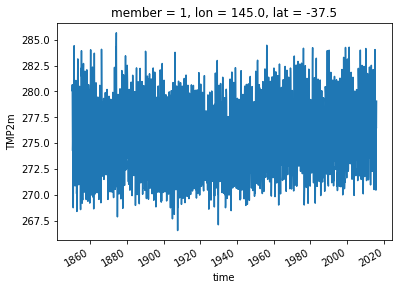

In [5]:
# check detrending worked 
temp_data.sel(member=1).sel(lon=144.9, lat=-37.38, method='nearest').plot()

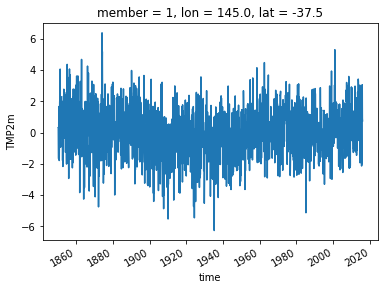

In [6]:
temp_data_dt.sel(member=1).sel(lon=144.9, lat=-37.38, method='nearest').plot()

In [7]:
# Save progress to file
climtas.io.to_netcdf_throttled(temp_data_dt, '/g/data/w40/rl5183/progress_files/TNn_detrended.nc')

  0%|          | 0/640 [00:00<?, ?it/s]

In [3]:
temp_data_dt = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TNn_detrended.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110}).sel(time=slice('1901-11', '2015-10'))

In [9]:
temp_data_dt

,Array,Chunk
Bytes,52.84 GiB,126.29 MiB
Shape,"(80, 1368, 180, 360)","(1, 1368, 110, 110)"
Count,1281 Tasks,640 Chunks
Type,float64,numpy.ndarray


### Open HadISST dataset

In [4]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [5]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [6]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [7]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [8]:
def ensemble_regression(data, nino):
    
    # Take min over every quarter 
    quarterly_data = data.resample(time='QS-NOV').min('time')

    # Calculate instantaneous regression 
    quarterly_regression = func.regress_nino_by_month(quarterly_data, nino)
    
    return quarterly_regression 

In [9]:
regression_list = []
for m in temp_data_dt.member:
    regression_list.append(ensemble_regression(temp_data_dt.sel(member=m), nino_ndj))

In [10]:
regressions = xr.concat(regression_list, dim='member')

In [11]:
regressions 

<xarray.DataArray (member: 80, month: 4, lat: 180, lon: 360)>
array([[[[ 3.51537999e-01,  3.48998874e-01,  3.45052712e-01, ...,
           3.57169101e-01,  3.57697023e-01,  3.53110808e-01],
         [ 4.39567594e-01,  4.28681744e-01,  4.21320523e-01, ...,
           4.37653917e-01,  4.40448857e-01,  4.43165861e-01],
         [ 1.95290963e-01,  1.98034940e-01,  1.98808472e-01, ...,
           2.42513418e-01,  2.25537899e-01,  2.10788176e-01],
         ...,
         [-1.64632667e-03, -7.51246911e-03, -5.31473563e-03, ...,
          -8.45332336e-04, -1.87102631e-03, -2.92720933e-03],
         [-1.05680386e-01, -1.03007376e-01, -1.01429036e-01, ...,
          -1.01222294e-01, -1.00785408e-01, -1.05995222e-01],
         [-2.44106649e-01, -2.44709839e-01, -2.41665713e-01, ...,
          -2.47931714e-01, -2.44398911e-01, -2.39977685e-01]],

        [[-5.21781625e-02, -4.97190089e-02, -4.82049001e-02, ...,
          -4.26774481e-02, -4.61712871e-02, -4.56892898e-02],
         [-4.77936307e-01, -4.54453135e-01, -4.27150958e-01, ...,
          -4.50958697e-01, -4.59242692e-01, -4.64075618e-01],
         [-3.59939390e-01, -3.32886384e-01, -3.03449672e-01, ...,
          -3.80821901e-01, -3.48932052e-01, -3.44098470e-01],
...
         [-1.24900653e-01, -1.24611834e-01, -1.27553748e-01, ...,
          -1.15334031e-01, -1.15920269e-01, -1.19705839e-01],
         [-6.68266257e-02, -7.71527647e-02, -8.10307943e-02, ...,
          -6.07500209e-02, -6.13669650e-02, -6.05043949e-02],
         [-1.10785377e-01, -1.11445433e-01, -1.14289777e-01, ...,
          -1.15666728e-01, -1.10747918e-01, -1.09002311e-01]],

        [[ 1.99671773e-01,  2.00823638e-01,  1.98869412e-01, ...,
           2.00814268e-01,  2.01029190e-01,  1.97184139e-01],
         [ 1.95937481e-01,  1.94236993e-01,  1.87773592e-01, ...,
           2.12520781e-01,  2.02299460e-01,  2.01124482e-01],
         [ 1.36721999e-01,  1.39752670e-01,  1.37707385e-01, ...,
           1.44177065e-01,  1.41496051e-01,  1.40899113e-01],
         ...,
         [-2.49309544e-02, -2.75449204e-02, -2.89683112e-02, ...,
          -2.11832992e-03, -1.11961524e-02, -1.92354623e-02],
         [-8.38769767e-02, -9.08187004e-02, -9.95347830e-02, ...,
          -3.95765605e-02, -5.24902864e-02, -6.99566771e-02],
         [ 4.70858492e-02,  4.72928375e-02,  4.87699398e-02, ...,
           5.23071582e-02,  4.74553432e-02,  4.73557375e-02]]]])
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 2 5 8 11

In [12]:
# Save as netcdf
regressions.to_netcdf('/g/data/w40/rl5183/20CR/temp/TNn_regressions_all_members_1901_2015.nc')

In [2]:
regressions = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TNn_regressions_all_members_1901_2015.nc')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-4-97d9abcf3400>:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('20CR_ensemble_regression_TNn_NDJ.pdf', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-4-97d9abcf3400>:22: MatplotlibDeprecationWarning: savefig() go

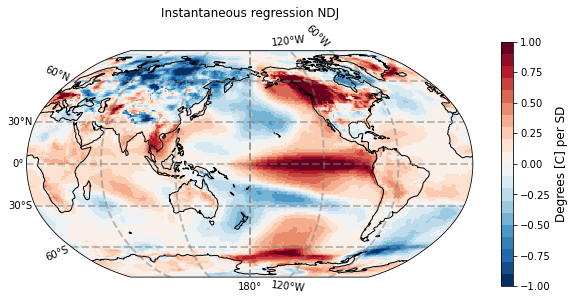

In [4]:
# Plot ensemble mean to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = regressions.sel(month=11).mean(dim='member').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C] per SD', fontsize=12)

# Save figure as pdf
# plt.savefig('20CR_ensemble_regression_TNn_NDJ.pdf', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [15]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, regressions)

In [16]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=regressions.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/temp/TNn_ensemble_std_1901_2015.nc')